Hey

In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [3]:
#MY COMPUTER

#READING INITIAL TRAIN DATA
# data_traff_train = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_traff.sas7bdat')
# data_train = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
# data_traff_test = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_traff_test.sas7bdat')
# data_test = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_fe_test.sas7bdat')
# data_test2 = pd.read_sas('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data/test/hash_school_dpi_model_test.sas7bdat')


#WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# data_train.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/train/data_train.parquet.gzip',compression='gzip')
# data_test.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/test/data_test.parquet.gzip',compression='gzip')

# READING INITIAL TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/train/data_train.parquet.gzip')
data_test = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/test/data_test.parquet.gzip')


In [17]:
# ED'S COMPUTER

# READING INITIAL TRAIN DATA
# data_traff_train = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_traff.sas7bdat')
# data_train = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/train/hash_school_dpi_model_fe.sas7bdat')

#WRITING INITIAL TRAIN DATA TO PARQUET
# data_traff.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/hash_school_dpi_model_traff.parquet.gzip',compression='gzip')
# 

# READING INITIAL TEST DATA
# data_traff_test = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_traff_test.sas7bdat')
# data_test = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_fe_test.sas7bdat')
# data_test2 = pd.read_sas('C:/Users/Edward/Documents/Appleolga/Final_pro/model2/test/hash_school_dpi_model_test.sas7bdat')

#WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# data_train.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_train.parquet.gzip',compression='gzip')
# data_test.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/test/data_test.parquet.gzip',compression='gzip')

# READING INITIAL TRAIN AND TEST DATA FROM PARQUET
data_train= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_train.parquet.gzip')
data_test = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/test/data_test.parquet.gzip')





In [ ]:
#DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

# print(data_train.shape)
# print(data_traff_train.shape)
# data_traff_train = data_traff_train.drop_duplicates()
# data_train = data_train.drop_duplicates()
# print(data_train.shape)
# print(data_traff_train.shape)

# data_train = data_train.merge(data_traff_train, on = 'abon_id')
# del data_traff_train

# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)
# data_test = data_test.drop_duplicates()
# data_test2 = data_test2.drop_duplicates()
# data_traff_test = data_traff_test.drop_duplicates()
# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)

# data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
# del data_test2
# del data_traff_test


In [4]:
#Marking categorical columns

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list


In [30]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
879


In [34]:
traffic_cols = ['traff_m5', 'traff_m3','traff_m2','traff_m1']
data_train_num = data_train[num_col_list]
data_test_num = data_test[num_col_list]

In [7]:
# data_train_num = data_train_num.assign(var = data_train_num[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_train_num = data_train_num.assign(var_quant = pd.qcut(data_train_num['var'], 10,labels = False))

# data_test_num = data_test_num.assign(var = data_test_num[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_test_num = data_test_num.assign(var_quant = pd.qcut(data_test_num['var'], 10,labels = False))


In [8]:
# WRITING TRAIN AND TEST DATA WITH VARIANCE AND QUANTILES TO PARQUET

#MY COMPUTER
data_train_num.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip',compression='gzip')
data_test_num.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_test_num.parquet.gzip',compression='gzip')

#ED's COMPUTER
# data_train_num.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num.parquet.gzip',compression='gzip')
# data_test_num.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_test_num.parquet.gzip',compression='gzip')


In [9]:
# READING TRAIN AND TEST DATA WITH VARIANCE AND QUANTILES FROM PARQUET

#MY COMPUTER
data_train_num= pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip')
data_test_num= pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_test_num.parquet.gzip')

#ED's COMPUTER
# data_train_num= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num.parquet.gzip')
# data_test_num= pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_test_num.parquet.gzip')

In [10]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask        
        
# # test = pd.DataFrame(data = np.array([1,2,5,100,2,5,1000]), columns = ['test'])
# # mark_outliers(test, test)

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [ ]:
# data_train_num_outliers_mask = mark_outliers(data_train_num)
# data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
# del data_train_num_outliers_mask

In [22]:
# data_train_num_corr = data_train_num.corr()

In [24]:
# WRITING DATA_TRAIN_NUM CORRELATION TO PARQUET

#MY COMPUTER
# data_train_num_corr.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_corr.parquet.gzip',compression='gzip')

#ED's COMPUTER
# data_train_num_corr.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_corr.parquet.gzip',compression='gzip')


In [12]:
# READING DATA_TRAIN_NUM CORRELATION FROM PARQUET

#MY COMPUTER
data_train_num_corr = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_corr.parquet.gzip')

#ED's COMPUTER
# data_train_num_corr = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_corr.parquet.gzip')


In [ ]:
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [35]:
# WRITING TRAIN DATA INFO DF TO PARQUET

#MY COMPUTER
# data_train_num_info.to_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num.parquet.gzip',compression='gzip')

#ED's COMPUTER
data_train_num_info.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_info.parquet.gzip',compression='gzip')


In [13]:
# READING TRAIN DATA INFO DF FRFOM PARQUET

#MY COMPUTER
data_train_num_info = pd.read_parquet('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_parquet/data_train_num_info.parquet.gzip')

#ED's COMPUTER
# data_train_num_info = pd.read_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/data_train_num_info.parquet.gzip')


In [15]:
def highlight_p75(s):
    '''
    highlight the maximum in a Series.
    '''
    is_max = s >= s.quantile(0.75)
    return ['background-color: salmon' if v else '' for v in is_max]

In [16]:
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', ascending=False).\
                                                style.apply(highlight_p75,
                                                            subset=['%outliers', '%nans']).\
                                                            format({'%of_fr_univalue': "{:.2%}",
                                                                    '%of_unfr_univalue': "{:.2%}",
                                                                    '%outliers': "{:.2%}",
                                                                    '%nans': "{:.2%}",
                                                                    'target': "{:.2f}"})
data_train_num_info_style

In [17]:
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape)

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'target', ascending=False).\
                            style.apply(highlight_p75,
                                        subset=['%outliers', '%nans']).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

(801, 7)


In [18]:
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape)

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_p75,
                                        subset=['%outliers', '%nans']).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

(57, 7)


In [19]:
num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.9)]['col'].to_list()
len(num_cols_to_use)

54

In [20]:
# data_descr = pd.read_csv('C:/Users/Edward/Documents/Appleolga/Final_pro/data_descr.csv', names=['feature', 'descr'])

data_descr = pd.read_csv('C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/data_descr.csv', names=['feature', 'descr'])

In [21]:
data_train_num_info = pd.merge(data_train_num_info, data_descr, how='left', left_on='col', right_on='feature')
data_train_num_info.loc[data_train_num_info['descr'].isna(), 
                        'descr'] = data_train_num_info.loc[data_train_num_info['descr'].isna(), 'col']

In [22]:
data_train_num_info = data_train_num_info.assign(feature_clear = data_train_num_info['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

data_train_num_info['feature_clear'] = data_train_num_info.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

data_train_num_info = data_train_num_info.drop('feature', axis =1)

In [23]:
num_cols_to_use = list(data_train_num_info.loc[data_train_num_info['col'].isin(num_cols_to_use)].\
                                       groupby('feature_clear')['col'].max('target').values)


In [24]:
data_train_num_filtered = data_train_num[num_cols_to_use + ['var', 'target']]
data_train_num_filtered.shape


(250017, 27)

In [25]:
# cat_col_list = cat_col_list['col_name'].to_list()

big_var_df = data_train_num_filtered[data_train_num_filtered['var_quant'] == 9]

big_var_df = big_var_df.merge(data_train[cat_col_list], how  = 'left', left_index = True, right_index = True)
big_var_df.shape

(25002, 59)

In [ ]:
big_var_df.isnull().sum()

In [43]:
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df.drop('target', axis =1).fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)

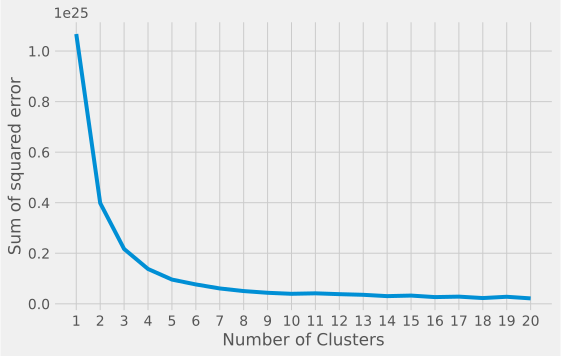

In [45]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [47]:
kmeans_batch = MiniBatchKMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch = kmeans_batch.fit_predict(X_train_big_var)

big_var_df = big_var_df.assign(cluster = y_kmeans_batch)


In [48]:
big_var_df.groupby('cluster')['target'].describe()

count       mean        std  min        25%        50%        75%  \
cluster                                                                        
0         8800.0  22.048544  21.525598  0.0   1.995408  17.343114  35.163921   
1         1281.0  45.591731  34.513016  0.0  11.052523  48.969279  70.230572   
2        10750.0  13.288756  17.498933  0.0   0.000367   6.522565  19.612647   
3         4171.0  32.475058  26.422165  0.0   6.740191  31.005511  51.833443   

                max  
cluster              
0        149.139397  
1        149.926668  
2        149.191279  
3        147.163719

In [107]:
clust0

traff_m5   traff_m3   traff_m2   traff_m1
0     37.269789  44.743169  19.664730  46.955222
1     16.890106  29.949622  35.416218  33.929386
2     30.270427  10.543380  27.633632  46.057266
3     19.158141  40.637463  35.420516  39.399383
4     16.090237  28.475979  28.285094  11.614739
...         ...        ...        ...        ...
8795   0.000000   0.000000  21.223674  23.866091
8796   0.000000   0.000000  27.571478  43.878366
8797   0.000000   0.000000  28.990493  81.906156
8798   0.000000   0.000000  20.502577   5.566595
8799   0.000000   0.000000  25.897833  22.304602

[8800 rows x 4 columns]

In [116]:
clust0.index

RangeIndex(start=0, stop=8800, step=1)

IndexError: index 2 is out of bounds for axis 0 with size 2

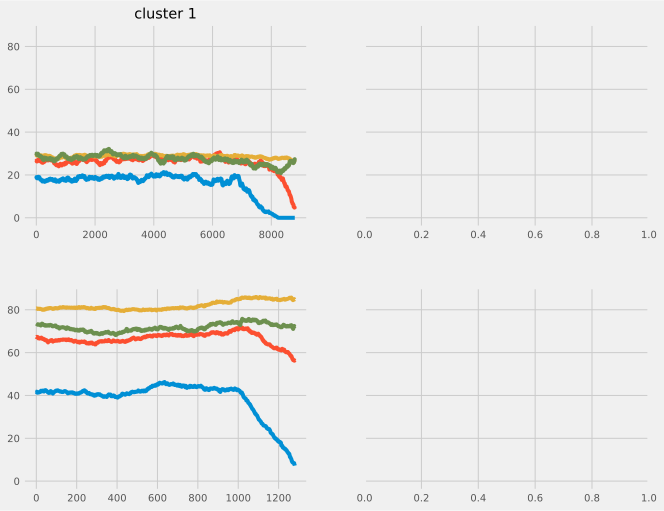

In [131]:
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey = True)
fig.subplots_adjust(hspace=0.3)
plt.rcParams.update({'font.size':10})

i, j = 0,0

for cl in big_var_df['cluster'].unique():
       
    rolling_window = 300
    
    clust = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == cl][traffic_cols].values, columns = traffic_cols)
    clust_smoothed = clust.rolling(rolling_window, center = True, min_periods=1).mean()
    sns.lineplot(ax=axes[i,j], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 0].values)
    sns.lineplot(ax=axes[i,j], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 1].values)
    sns.lineplot(ax=axes[i,j], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 2].values)
    sns.lineplot(ax=axes[i,j], x=clust_smoothed.index, y=clust_smoothed.iloc[: , 3].values)
    axes[i,j].set_title('cluster ' + str(cl))
    
    j += 1
    if j < = 1:
        i += 1
    else:
        
        


# sns.legend(traffic_cols);


In [132]:
big_var_df['cluster'].unique()

array([0, 2, 1, 3])

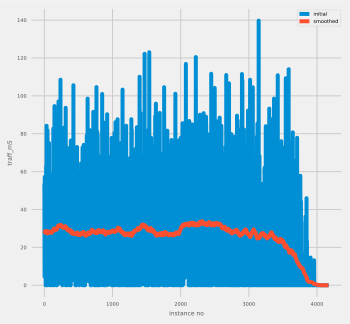

In [120]:
temp = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == 3]['traff_m5'].values)
temp_smoothed = temp.rolling(200, center = True, min_periods=1).mean()


plt.figure(figsize=(5, 5))
plt.ylabel("traff_m5")
plt.xlabel("instance no")
plt.plot(temp, label="initial")
plt.plot(temp_smoothed, label="smoothed")

plt.legend();

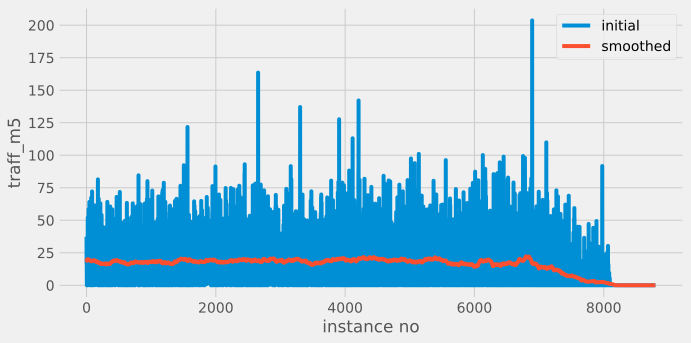

In [71]:
temp = pd.DataFrame(data = big_var_df[big_var_df['cluster'] == 0]['traff_m5'].values)
temp_smoothed = temp.rolling(200, center = True, min_periods=1).mean()


plt.figure(figsize=(10, 5))
plt.ylabel("traff_m5")
plt.xlabel("instance no")
plt.plot(temp, label="initial")
plt.plot(temp_smoothed, label="smoothed")

plt.legend();

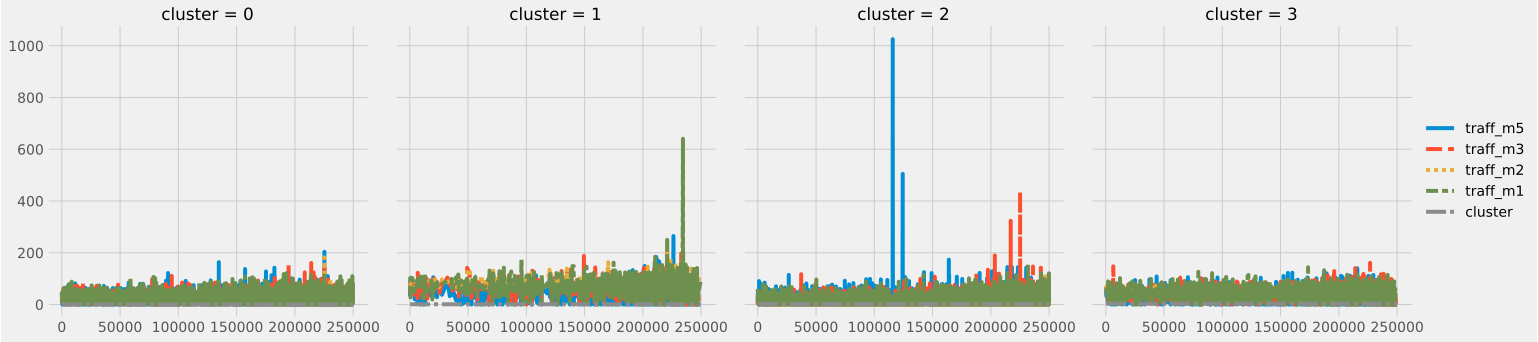

In [55]:
sns.relplot(data=big_var_df[traffic_cols + ['cluster']], kind="line", col = 'cluster')

In [ ]:
cov = data_train[num_cols_list].cov()
vals, vecs = scipy.linalg.eig(cov)

import decimal

for i, val in enumerate(vals):
    print('var {}: '.format(i+1), decimal.Decimal(val.real))

In [ ]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total','clc_no_vas_roam_std_mnt3','all_clc_mea_mnt3']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [ ]:
traffic_cols = ['traff_m5', 'traff_m3','traff_m2','traff_m1']
traffic_cols.sort()
traffic_cols_plus_target = ['traff_m5', 'traff_m3','traff_m2','traff_m1', 'target']
traffic_cols_plus_target.sort()

In [ ]:
traffic_cols_plus_target

### ANALYSING TRAFFIC TENDENCIES


In [ ]:
data_traffic = data_train[traffic_cols_plus_target]
# data_traffic.describe()

data_traffic_test = data_test[traffic_cols_plus_target]




In [ ]:
data_traffic = data_traffic.assign(var = data_traffic.apply(lambda x: x.var(), axis=1))
# data_traffic.describe()

data_traffic_test = data_traffic_test.assign(var = data_traffic_test.apply(lambda x: x.var(), axis=1))

In [ ]:
var_quantiles = data_traffic['var'].quantile(np.linspace(.1, 1, 19, 0.5))
data_traffic = data_traffic.assign(var_quant = pd.qcut(data_traffic['var'], 10,labels = False))



var_quantiles_test = data_traffic_test['var'].quantile(np.linspace(.1, 1, 19, 0.5))
data_traffic_test = data_traffic_test.assign(var_quant = pd.qcut(data_traffic_test['var'], 10,labels = False))

In [ ]:
data_traffic.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_traffic_with_var_quant.parquet.gzip',compression='gzip')
# data_nulls_less_60p.to_parquet('C:/Users/Edward/Documents/Appleolga/Final_pro/model2_parquet/train/data_nulls_less_60p.parquet.gzip',compression='gzip')

#### Trends

In [ ]:
enum = np.arange(1, len(traffic_cols)+1, 1)
data_traffic = data_traffic.assign(slope_traff = data_traffic.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_traffic_test = data_traffic_test.assign(slope_traff = data_traffic_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

In [ ]:
xmin = X.iloc[:, 0].min()
xmax = X.iloc[:, 0].max()
ymin = y.min()
ymax = y.max()

fig, axs = plt.subplots(ncols=2, nrows = 3, sharey=True, figsize=(7, 4))
# fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

ax = axs[0, 0]
hb = ax.hexbin(X.iloc[:, 0], y, gridsize=50, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title(X.columns[0])
cb = fig.colorbar(hb, ax=ax)


xmin = X.iloc[:, 1].min()
xmax = X.iloc[:, 1].max()

ax = axs[0, 1]
hb = ax.hexbin(X.iloc[:, 1], y, gridsize=50,  bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title(X.columns[1])
cb = fig.colorbar(hb, ax=ax)


xmin = X.iloc[:, 2].min()
xmax = X.iloc[:, 2].max()

ax = axs[0, 2]
hb = ax.hexbin(X.iloc[:, 2], y, gridsize=50,  bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title(X.columns[2])
cb = fig.colorbar(hb, ax=ax)


xmin = X.iloc[:, 3].min()
xmax = X.iloc[:, 3].max()

ax = axs[1, 1]
hb = ax.hexbin(X.iloc[:, 3], y, gridsize=50,  bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title(X.columns[3])
cb = fig.colorbar(hb, ax=ax)
plt.show()


In [ ]:
data.shape

### TRAIN-TEST

In [ ]:
# data_traffic = data[traffic_cols]
# data_nulls_filled0 = data_traffic.fillna(0)

data_nulls_filled0 = data_train[cols_to_use].fillna(0)
data_for_pca_totals = data_nulls_filled0[totals_for_pca]
data_for_pca_dpi = data_nulls_filled0[dpi_for_pca]

In [ ]:
data_nulls_filled0_test = data_test[cols_to_use].fillna(0)
data_for_pca_totals_test = data_nulls_filled0_test[totals_for_pca]
data_for_pca_dpi_test = data_nulls_filled0_test[dpi_for_pca]

In [ ]:
sc_x_traf = StandardScaler()

X_std = sc_x_traf.fit_transform(data_for_pca_totals)

pca = PCA(random_state=3)
X_pca_totals = pca.fit_transform(X_std)
pd.DataFrame(pca.explained_variance_ratio_).style.format("{:.2%}")


In [ ]:
sc_x_traf_test = StandardScaler()

X_std_test = sc_x_traf_test.fit_transform(data_for_pca_totals_test)

pca_test = PCA(random_state=3)
X_pca_totals_test = pca_test.fit_transform(X_std_test)
pd.DataFrame(pca_test.explained_variance_ratio_).style.format("{:.2%}")

In [ ]:
sc_x_traf = StandardScaler()

X_std = sc_x_traf.fit_transform(data_for_pca_dpi)

pca = PCA(random_state=3)
X_pca_dpi = pca.fit_transform(X_std)
pd.DataFrame(pca.explained_variance_ratio_).style.format("{:.2%}")

In [ ]:
sc_x_traf_test = StandardScaler()

X_std_test = sc_x_traf_test.fit_transform(data_for_pca_dpi_test)

pca_test = PCA(random_state=3)
X_pca_dpi_test = pca_test.fit_transform(X_std_test)
pd.DataFrame(pca_test.explained_variance_ratio_).style.format("{:.2%}")

In [ ]:
sc_x_traf = StandardScaler()

X_std = sc_x_traf.fit_transform(data_for_pca_dpi)

pca = PCA(n_components = 2, random_state=3)
X_pca_dpi = pca.fit_transform(X_std)

sc_x_traf_test = StandardScaler()

X_std_test = sc_x_traf_test.fit_transform(data_for_pca_dpi_test)

pca_test = PCA(n_components = 2, random_state=3)
X_pca_dpi_test = pca_test.fit_transform(X_std_test)


In [ ]:
# from sklearn import datasets


# X=X_traf_std
# y=data['target']

# pca = PCA()
# pca.fit(X,y)
# x_new = pca.transform(X)   

# def myplot(score,coeff,labels=None):
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]

#     plt.scatter(xs ,ys, c = y) #without scaling
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

# plt.xlabel("PC{}".format(1))
# plt.ylabel("PC{}".format(2))
# plt.grid()

# #Call the function. 
# myplot(x_new[:,0:2], pca. components_) 
# plt.show()

In [ ]:
model = PCA(n_components=5).fit(X_traf_std)
X_pc = model.transform(X_traf_std)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [traffic_cols[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [ ]:
df

In [ ]:
xmin = var.min()
xmax = var.max()
ymin = y.min()
ymax = y.max()

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb = ax.hexbin(var, y, gridsize=50, cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

ax = axs[1]
hb = ax.hexbin(var, y, gridsize=50, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import mutual_info_regression
# from matplotlib import pyplot
 
# # feature selection
# def select_features(X_train, y_train, X_test):
#     # configure to select all features
#     fs = SelectKBest(score_func=mutual_info_regression, k='all')
#     # learn relationship from training data
#     fs.fit(X_train, y_train)
#     # transform train input data
#     X_train_fs = fs.transform(X_train)
#     # transform test input data
#     X_test_fs = fs.transform(X_test)
#     return X_train_fs, X_test_fs, fs
 
# X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# # what are scores for the features
# for i in range(len(fs.scores_)):
#     print('Feature %d: %f' % (i, fs.scores_[i]))
# # plot the scores
# pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
# pyplot.show()

In [ ]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [ ]:
#class sklearn.feature_selection.VarianceThreshold(threshold=0.0)
#SPEARMAN Correlation

In [ ]:
data_nulls_filled0 = data_train[cols_to_use].drop(totals_for_pca, axis=1).fillna(0)
data_nulls_filled0 = data_nulls_filled0.drop(dpi_for_pca, axis=1)
data_nulls_filled0 = data_nulls_filled0.assign(pca1=X_pca_totals[:, 0], 
                                               pca2=X_pca_dpi[:, 0],
                                               pca3=X_pca_dpi[:, 1], 
                                               var_quant = data_traffic['var_quant'],
                                               slope_traff = data_traffic['slope_traff'])


# data_nulls_filled0 = data[cols].drop(totals_for_pca, axis=1).fillna(0)
# data_nulls_filled0 = data_nulls_filled0.drop(dpi_for_pca, axis=1)
# data_nulls_filled0 = data_nulls_filled0.assign(pca1=X_pca_totals[:, 0], 
#                                                pca2=X_pca_dpi[:, 0],
#                                                pca3=X_pca_dpi[:, 1], 
#                                                var_quant = data_traffic['var_quant'])


# data_nulls_filled0 = data_nulls_filled0.drop('gprs_tar_vol_mea_mnt3', axis=1)


# data_nulls_filled0 = data[cols].fillna(0)

In [ ]:
data_nulls_filled0_test = data_test[cols_to_use].drop(totals_for_pca, axis=1).fillna(0)
data_nulls_filled0_test = data_nulls_filled0_test.drop(dpi_for_pca, axis=1).fillna(0)
data_nulls_filled0_test = data_nulls_filled0_test.assign(pca1=X_pca_totals_test[:, 0], 
                                                         pca2=X_pca_dpi_test[:, 0],
                                                         pca3=X_pca_dpi_test[:, 1], 
                                                         var_quant = data_traffic_test['var_quant'], 
                                                         slope_traff = data_traffic_test['slope_traff'])


# data_nulls_filled0_test = data_test[cols].drop(totals_for_pca, axis=1).fillna(0)
# data_nulls_filled0_test = data_nulls_filled0_test.drop(dpi_for_pca, axis=1).fillna(0)
# data_nulls_filled0_test = data_nulls_filled0_test.assign(pca1=X_pca_totals_test[:, 0], 
#                                                          pca2=X_pca_dpi_test[:, 0],
#                                                          pca3=X_pca_dpi_test[:, 1], 
#                                                          var_quant = data_traffic_test['var_quant'])
# # data_nulls_filled0 = data[cols].fillna(0)


# data_nulls_filled0_test = data_nulls_filled0_test.drop('gprs_tar_vol_mea_mnt3', axis=1)

In [ ]:
X, y = data_nulls_filled0.loc[:, data_nulls_filled0.columns != 'target'], data_nulls_filled0.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

In [ ]:
X_test_test, y_test_test = data_nulls_filled0_test.loc[:, data_nulls_filled0_test.columns != 'target'], data_nulls_filled0_test.target

In [ ]:
big_var = data_nulls_filled0[data_nulls_filled0['var_quant'] == 9]
big_var = big_var.assign(slope_sign = big_var.apply(lambda x: -1 if x['slope_traff'] < 0 \
                                                    else (o if x['slope_traff'] == 0 else 1),
                                                   axis = 1))

In [ ]:
big_var[big_var['traff_m1'] == 0].sort_values(by = 'target', ascending=False).head(30)


In [ ]:
# LINEAR REGRESSION RESULTS


# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# Slope: 0.15
# Intercept: 1.30
# RMSE train: 8.584659, test: 8.514558
# R^2 train: 0.474909, test: 0.492442


#hight corr target columns, stats chosen by highest correlation with target

#MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d','MV_ap_innet_out_v','MV_AP_total',
#'non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3','data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1',
# 'content_cnt_mea_mnt3','clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration','dpi_upload',
# 'dpi_download','dpi_events','dpi_day_cnt','target','traff_m5','traff_m3','traff_m2', 'traff_m1']
# Slope: 0.04
# Intercept: -2.23
# RMSE train: 8.511254, test: 8.466906
# R^2 train: 0.483850, test: 0.498107


#withou traffic columns with their STD instead
# Slope: 0.02
# Intercept: -3.36
# RMSE train: 8.940543, test: 8.900981
# R^2 train: 0.430470, test: 0.445326


#pca1 and pca2 instead of traffic columns
# Slope: 0.04
# Intercept: 2.00
# RMSE train: 8.640514, test: 8.599313
# R^2 train: 0.468054, test: 0.482287



#all data standard scaled
# Slope: 0.01
# Intercept: 0.00
# RMSE train: 0.000000, test: 8.466906
# R^2 train: 1.000000, test: 0.498107

#totals_for_pca + dpi_for_pca  = one PCA taken from totals, 2 from dpi

# Slope: 0.04
# Intercept: 2656217253792.36
# RMSE train: 8.374349, test: 8.331864
# R^2 train: 0.500321, test: 0.513989

# with traffic variance quantiles, different regression model by quantile 
# Train set results

# RMSE train: 7.998114, test: 8.066895
# R^2 train: 0.543879, test: 0.545170

# Test set results

# RMSE test_test: 8.130670
# R^2 test_test: 0.511574

# with traffic variance quantiles, different regression model by quantile + slope coeff for traffic data

# Train set results

# RMSE train: 7.998114, test: 8.066895
# R^2 train: 0.543879, test: 0.545170

# Test set results

# RMSE test_test: 8.130670
# R^2 test_test: 0.511574

# with traffic variance quantiles, different regression model by quantile + slope coeff for traffic data
#gprs_tar_vol_mea_mnt3 column dropped based on low coefficients 

# Train set results

# RMSE train: 7.998185, test: 8.067140
# R^2 train: 0.543871, test: 0.545142

# Test set results

# RMSE test_test: 8.130594
# R^2 test_test: 0.511583
    
#Choosing features by regression coefficients did not work out!!!



In [ ]:
slr = LinearRegression()

slr.fit(X_train, y_train)


print('Slope: {:.2f}'.format(slr.coef_[0]))
print('Intercept: {:.2f}'.format(slr.intercept_))

y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



y_test_test_pred = slr.predict(X_test_test)

print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test, y_test_test_pred)))

In [ ]:
X_list, y_list = [], []
df_list = []

coeff = []

for g, v in data_nulls_filled0.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
# df_list = []

for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    slr = LinearRegression()

    slr.fit(X_tr, y_tr)
    train_pred = pd.Series(data = slr.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
#     print(y_train_pred.shape)
    
    test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print(str(X_tr['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    
    coeff.append(slr.coef_)    
    
    joblib_file = "joblib_model"+"_q"+str(X_tr['var_quant'].unique()[0])+".pkl"
    joblib.dump(slr, joblib_file)


In [ ]:
df_coeff= pd.DataFrame()

for i in coeff:
    
    df_coeff= df_coeff.append(pd.Series(i), ignore_index = True)

df_coeff.columns = X_train.columns

def abs_more_than_0_02(value): 
    
    if abs(value) > 0.02:
        color = 'green'
    else:
        color = 'red'
        
    return 'color: %s' % color
    

df_coeff.T.style.applymap(abs_more_than_0_02)


In [ ]:
feature_list_by_var_quantile = []
df_coeff = df_coeff.T
for col in df_coeff.columns:
    feature_list_by_var_quantile.append(df_coeff[(df_coeff[col] > 0.02)|(df_coeff[col] < -0.02)].index)


In [ ]:
X_list, y_list = [], []
df_list = []


for g, v in data_nulls_filled0_test.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0])+".pkl"
    slr = joblib.load(joblib_file)
    

    test_test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    
    print(str(X_ts['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 train: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
    
   

In [ ]:
X_ts_increase = X_ts[X_ts['slope_traff'] > 0 ]
X_ts_increase.head(20)

In [ ]:
plt.scatter(y_ts, test_test_pred, color = "red")
plt.plot(y_ts, slr.predict(X_ts), color = "green")
# plt.title("Salary vs Experience (Training set)")
plt.xlabel("y_real")
plt.ylabel("y_predicted")
plt.show()

In [ ]:
# data_nulls_filled0_test_pred = data_nulls_filled0_test.merge(y_test_test_pred.rename('y_pred'), \
#                                                              left_index=True, right_index=True)

# data_nulls_filled0_pred = X_train.merge(y_train.rename('target'), \
#                                                              left_index=True, right_index=True)
# data_nulls_filled0_pred = data_nulls_filled0_pred.merge(y_train_pred.rename('y_pred'), \
#                                                              left_index=True, right_index=True)

# data_nulls_filled0_test_pred.groupby('var_quant')[('target', 'y_pred')].describe()

# data_nulls_filled0_pred.groupby('var_quant')[('target', 'y_pred')].describe()

In [ ]:
print('Train set results')
print()

print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test, y_test_test_pred)))

In [ ]:
# plt.scatter(y_test, y_test_pred)

In [ ]:
# LASSO Results

# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# RMSE train: 8.585720, test: 8.520605
# R^2 train: 0.474779, test: 0.491720


##hight corr target columns, stats chosen by highest correlation with target
# ALPHA = 0.01

#MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d','MV_ap_innet_out_v','MV_AP_total',
#'non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3','data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1',
# 'content_cnt_mea_mnt3','clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration','dpi_upload',
# 'dpi_download','dpi_events','dpi_day_cnt','target','traff_m5','traff_m3','traff_m2', 'traff_m1']

# RMSE train: 8.519896, test: 8.471351
# R^2 train: 0.482802, test: 0.497580


#withou traffic columns with their STD instead
#RMSE train: 8.948037, test: 8.904686
# R^2 train: 0.429515, test: 0.444865

#pca1 and pca2 instead of traffic columns
# RMSE train: 8.653119, test: 8.603949
# R^2 train: 0.466500, test: 0.481728

#totals_for_pca + dpi_for_pca  = one PCA taken from totals, 2 from dpi
# RMSE train: 8.518591, test: 8.470900
# R^2 train: 0.482960, test: 0.497633

In [ ]:
sc_y = StandardScaler()
sc_x = StandardScaler()


X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()


In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_std,y_train_std)
y_train_pred_std = lasso.predict(X_train_std)
y_test_pred_std = lasso.predict(X_test_std)

print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, sc_y.inverse_transform(y_train_pred_std), squared = False),
        mean_squared_error(y_test, sc_y.inverse_transform(y_test_pred_std), squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, sc_y.inverse_transform(y_train_pred_std)),
        r2_score(y_test, sc_y.inverse_transform(y_test_pred_std))))

In [ ]:
alpha = np.linspace(0.01,0.4,10)
r2_train =[]
r2_test =[]
RMSE_train = []
RMSE_test = []
norm = []
alpha = np.linspace(0.01,0.4,10)
for i in range(10):
    lasso = Lasso(alpha = alpha[i])
    lasso.fit(X_train_std,y_train_std)
    y_train_std = lasso.predict(X_train_std)
    y_test_std = lasso.predict(X_test_std)
    r2_train = np.append(r2_train,
              r2_score(y_train,sc_y.inverse_transform(y_train_std)))
    r2_test = np.append(r2_test,
              r2_score(y_test,sc_y.inverse_transform(y_test_std)))
    RMSE_train = np.append(RMSE_train, 
                        mean_squared_error(y_train,sc_y.inverse_transform(y_train_std), squared = False))
    RMSE_test = np.append(RMSE_test, 
                        mean_squared_error(y_test,sc_y.inverse_transform(y_test_std), squared = False))
    
    norm = np.append(norm,np.linalg.norm(lasso.coef_))

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(alpha,RMSE_train,label='RMSE_train')
plt.plot(alpha,RMSE_train)
plt.scatter(alpha,RMSE_test,label='RMSE_test')
plt.plot(alpha,RMSE_test)
# plt.scatter(alpha,norm,label = 'norm')
# plt.plot(alpha,norm)
# plt.ylim(-0.1,1)
# plt.xlim(0,.43)
plt.xlabel('alpha', size = 14)
plt.ylabel('RMSE_score',size = 14)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(alpha,r2_train,label='r2_train')
plt.plot(alpha,r2_train)
plt.scatter(alpha,r2_test,label='r2_test')
plt.plot(alpha,r2_test)
plt.scatter(alpha,norm,label = 'norm')
plt.plot(alpha,norm)
plt.ylim(-0.1,1)
plt.xlim(0,.43)
plt.xlabel('alpha', size = 14)
plt.ylabel('R2_score',size = 14)
plt.legend()
plt.show()

In [ ]:
# LGBM REGRESSOR RESULTS
# 
# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']
# RMSE = 10.709416107561104

##hight corr target columns, stats chosen by highest correlation with target

#MV_Traf_2G_d_Mb','MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb','MV_ARPU','MV_ap_4G_d','MV_ap_innet_out_v','MV_AP_total',
#'non_accum_internet_vol_max_mnt3','gprs_tar_vol_mea_mnt3','data_3g_tar_vol_mea_mnt3','data_3g_tv_cnt_max_mnt1',
# 'content_cnt_mea_mnt3','clc_no_vas_roam_std_mnt3','all_cnt_mea_mnt3','all_clc_mea_mnt3','dpi_duration','dpi_upload',
# 'dpi_download','dpi_events','dpi_day_cnt','target','traff_m5','traff_m3','traff_m2', 'traff_m1']

#RMSE = 10.635576100742853


#withou traffic columns with their STD instead
# RMSE =10.712767746328739

#pca1 and pca2 instead of traffic columns

#RMSE = 10.647630252841243


In [ ]:
model = ltb.LGBMRegressor()

parameters = {'n_estimators':[30, 50, 70, 100, 150], 
              'max_depth':[4, 6, 8, 10], 
              'boosting_type': ['gbdt'],
              'objective': ['regression'],
              'is_unbalance': [True], 
              'random_state': [10], 
              'num_leaves': [30],
              'feature_fraction':[0.5],
              'bagging_fraction': [0.8], 
              'bagging_freq':[15],
              'learning_rate':[0.01]}


from sklearn.metrics import make_scorer
score_func = make_scorer(mean_squared_error, squared=False)


grid_search = GridSearchCV(model, parameters, verbose=1, scoring=score_func, n_jobs=-1)
res = grid_search.fit(X_train, y_train)

res



In [ ]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

In [ ]:
predictions = grid_search.predict(X_test)



In [ ]:
mean_squared_error(y_test, predictions, squared=False)

In [ ]:
#closs_val_score(model, X, y ... )
#from skearn.model_selection import GridSearchCV

In [ ]:
start = timer()

# Fit the model to the training data
y_kmeans = kmeans.fit_predict(X)

end = timer()
print(timedelta(seconds=end-start))